# `ABaCo` demo: Mgnify study `MGYS00001135`

In this demo we will implement ABaCo for batch correction on Mgnify study [MGYS00001135](https://www.ebi.ac.uk/metagenomics/studies/MGYS00001135#overview) and ENA Bioproject [PRJEB13832](https://www.ebi.ac.uk/ena/browser/view/PRJEB13832), a proof-of-concept study for surveilling infections diseases and AMR via metagenomics analysis of local sewage samples in Copenhagen.

-----
**Data Description:**
- The metagenomics dataset collected by the Technical University of Denmark (DTU) and analysed via Mgnify [pipeline version 2.0](https://www.ebi.ac.uk/metagenomics/pipelines/2.0) is a dataset composed of 54 samples with 749 identified taxa at the genus level. 
- The samples were collected from 3 different wastewater treatment plant (WWTP) locations, accounting for the biological source of variation. 
- Samples were analyzed on 2 different dates accounting for the technical source of variation (i.e., batch effect).
- The sample data and metadata were retrieved from the [Mgnify API](https://docs.mgnify.org/src/docs/api.html) using the following [mgnifyapi repo](https://github.com/Multiomics-Analytics-Group/Retrieve_info_MGnifyAPI/tree/angel-learning) and stored as an Annotated Dataset (AnnData)[https://anndata.readthedocs.io/en/latest/index.html]. 

**Goal:**

With ABaCo the aim is to remove the technical variation (batch effect) while retaining the biological variation (wastewater treatment plant location). 

-----

To start we read in the dataset. 

In [1]:
import anndata as ad
import pandas as pd 
import numpy as np

# read in annotated dataset
adata = ad.read_h5ad("data/mgnify_MGYS00001135.h5ad")
# print details
adata

AnnData object with n_obs × n_vars = 54 × 749
    obs: 'analysis_id', 'sample_id', 'assembly_run_id', 'experiment_type', 'pipeline_version', 'study_id', 'instrument_platform', 'sample_name', 'biosample', 'sample_description', 'latitude', 'longitude', 'geolocation', 'biome_feature', 'biome_material', 'id', 'collection_date', 'collection_date_year', 'collection_date_month', 'collection_date_day', 'analysis_completed_date', 'analysis_completed_date_year', 'analysis_completed_date_month', 'analysis_completed_date_day', 'fname_run_id', 'erp_id', 'study_name', 'n_samples', 'biomes', 'ww_plant'
    var: 'sk', 'k', 'p', 'c', 'o', 'f', 'g'
    layers: 'abaco', 'clr_X', 'clr_abaco', 'normalized_X', 'normalized_abaco'

The columns (variables, vars) are the different taxa annotated with taxonomic ranks (sk = super kingdom, k = kingdom, p = phylum, c = class, o = order, f = family, g = genus).

The rows (observations, obs) are the metadata for the different samples in the study MYS00001135. The ones of interest for this demo are: 
- The `analysis_completed_date` which accounts for batch effect for our purposes, and
- `ww_plant` which are the different sampling locations and we will say is the biological variance that we wish to retain after batch correction.

-----

We can easily extract a df from anndata.

In [3]:
batch_col = 'analysis_completed_date'
bio_col = 'ww_plant'
id_col = 'index'

# the raw counts as df
df_taxa = adata.to_df()

# appending on the categorical data of interest
df_all = pd.concat([df_taxa, adata.obs[[batch_col, bio_col]]], axis=1).reset_index()
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Columns: 752 entries, index to ww_plant
dtypes: category(2), float64(749), object(1)
memory usage: 316.9+ KB


**`pd.DataFrame` Requirements for ABaCo:**

The dataset contains the following making it compatible with the ABaCo framework:

| id_col | batch_col  | bio_col  | count1 | count2 | ... |
|--------|------------|----------|--------|--------|-----|
| A      | 24/07/2025 | RA       | #      | #      | ... |
| B      | 15/06/2024 | RD       | #      | #      | ... |
| C      | 24/07/2025 | RL       | #      | #      | ... |

- The data has categorical columns: 
    1. unique ids to identify the observations/samples e.g. sample id col
    2. ids for the batch/factor groupings to be corrected by abaco. e.g. dates of sample analysis batch_col
    3. biological/experimental factor variation for abaco to retain when correcting batch effect e.g., sampling location bio_col

- And taxa counts to be trained on. 

We can use `abaco.BatchEffectPlots.plotPCoA()` to visualize any batch and biological effects based on the given categories. 

In [4]:
from abaco.BatchEffectPlots import plotPCoA

plotPCoA(
    data=df_all, 
    sample_label=id_col, 
    batch_label=batch_col,  
    experiment_label=bio_col,
)

>> clustergrammer2 backend version 0.18.0


- Batch effect (colours): 
    - Analysis of the samples were completed on 2 different dates which could result in a technical source of variation captured by the slight clustering of batches along PCo1
- Biological effect (shapes): 
    - The samples were collected from 3 different wwtps which we use as the biological source of variation for abaco to retain during batch correction. 
    - There isn't a clear clustering of shapes in the PCoA plot, but we can take a look at any other sim/diffs between locations that should be retained after abaco reconstruction.

### Preprocessing the count tables

The raw counts require further preprocessing because samples will have different total read counts due to technical differences during sequencing. We can normalize the samples to get relative abundances of the taxa summing to 1 (composition data), or we can enforce scale invariance instead by rarefying the data by subsampling reads to a target count number (e.g. if new total read count T is 100, then samples with > T reads will lose the leftover reads and samples with < T reads will be discarded completely.)

We will normalize to keep rare taxa.

In [ ]:
# normalize original data and store as additional anndata layer
adata.layers['normalized_X'] = (adata.X/adata.X.sum(axis=1).reshape(-1,1))
# sanity check 
adata.layers['normalized_X'].sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

Our normalized, compositional data (CoDa) is bound to a simplex. To move forward with any statistical tests or ML we can choose to map the coda to unconstrained vectors by log-ratio transforming (e.g., centred log-ratio via `skbio.stats.composition.clr()`) the data. 

In [6]:
from skbio.stats.composition import clr 

# CLR transform normalized data, replacing zeros with smallll val to avoid log(0)
adata.layers['clr_X'] = clr(np.where(adata.layers['normalized_X'] > 0, adata.layers['normalized_X'], 1e-10))

# save anndata with new layers
adata.write_h5ad("data/mgnify_MGYS00001135.h5ad")

In [ ]:
# preprocessing 



### The goal 

Here the aim of **ABaCo** is to: 
1) correct the batch effect (e.g., the points should no longer cluster by colour in the PCoA) while
2) maintaining biological variance (e.g., maintain group sim/diff).

Ideally, after using AbaCo to transform the data, the resulting PCoA will look like a colourful mixture of points and the metrics remain diff.

-----

## Using `ABaCo`

In [142]:
from abaco.ABaCo import metaABaCo
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instaantiate the ABaCo model
model = metaABaCo(
    data=df_all, # Pre-processed dataframe
    n_bios=df_all[bio_col].nunique(), # Number of biological groups in the data
    bio_label=bio_col, # Column where biological groups are labeled in the dataframe
    n_batches=df_all[batch_col].nunique(), # Number of batch groups in the data
    batch_label=batch_col, # Column where batch groups are labeled in the dataframe
    n_features=df_taxa.shape[1], # Number of features (taxonomic groups)
    prior="MoG", # Prior distribution 
    device=device, # Device
)

In [143]:
# train the model
model.correct(seed=42)

Training: VAE for learning meaningful embeddings: 100%|██████████| 1000/1000 [00:24<00:00, 41.27it/s, bio_penalty=0.0052, clustering_loss=0.0423, elbo=379.2844, epoch=999/1001, vae_loss=379.3319]
Training: Embeddings batch effect correction using adversrial training: 100%|██████████| 2000/2000 [00:52<00:00, 38.11it/s, adv_loss=-0.6822, bio_penalty=0.0419, clustering_loss=0.0423, disc_loss=0.6822, elbo=367.6367, epoch=1999/2001, vae_loss=367.7209]
Training: VAE decoder with masked batch labels: 100%|██████████| 2000/2000 [00:33<00:00, 59.24it/s, cycle_loss=0.0000, epoch=2000/2000, vae_loss=537.3471]


In [144]:
# Reconstruct the dataset using the trained ABaCo model
corrected_dataset = model.reconstruct(seed=42)

# Plot the PCoA of the reconstructed dataset
plotPCoA(
    data = corrected_dataset, 
    sample_label=id_col, 
    batch_label=batch_col, 
    experiment_label=bio_col
)

In [251]:
# save back to adata
adata.layers['abaco'] = corrected_dataset.set_index(id_col).drop(columns=[batch_col, bio_col]).values
adata.write_h5ad("data/mgnify_MGYS00001135.h5ad")

NameError: name 'corrected_dataset' is not defined

In [12]:
(adata.X - adata.layers['abaco']).sum(axis=1)  # check the difference between original and corrected data

array([   27.,   136.,   246.,  -133.,  -699.,   127.,   397.,   258.,
        -373.,   397.,   129., -1012.,   284.,   442.,  -389.,  -651.,
         135.,   384.,   485.,   418.,   -81.,    96.,   816.,   215.,
         585.,   186.,  -288.,  -571.,   -63.,  -600.,  -408.,   164.,
        -154.,  -615.,    97.,  -222.,  -303.,   -63.,  -428.,  -425.,
         239.,   474.,    40.,  -236.,     9.,    95.,   473.,   -69.,
          -8.,   294.,  -181.,   137.,   776.,  -469.])

## Preprocessing the count tables

The raw counts require further preprocessing because samples will have different total read counts due to technical differences during sequencing. We can normalize the samples to get relative abundances of the taxa summing to 1 (composition data), or we can enforce scale invariance instead by rarefying the data by subsampling reads to a target count number (e.g. if new total read count T is 100, then samples with > T reads will lose the leftover reads and samples with < T reads will be discarded completely.)

We will normalize to keep rare taxa.

In [229]:
# normalize original data
adata.layers['normalized_X'] = (adata.X/adata.X.sum(axis=1).reshape(-1,1))
# normalize abaco corrected data
adata.layers['normalized_abaco'] = (adata.layers['abaco']/adata.layers['abaco'].sum(axis=1).reshape(-1,1))
# sanity check 
adata

AnnData object with n_obs × n_vars = 54 × 749
    obs: 'analysis_id', 'sample_id', 'assembly_run_id', 'experiment_type', 'pipeline_version', 'study_id', 'instrument_platform', 'sample_name', 'biosample', 'sample_description', 'latitude', 'longitude', 'geolocation', 'biome_feature', 'biome_material', 'id', 'collection_date', 'collection_date_year', 'collection_date_month', 'collection_date_day', 'analysis_completed_date', 'analysis_completed_date_year', 'analysis_completed_date_month', 'analysis_completed_date_day', 'fname_run_id', 'erp_id', 'study_name', 'n_samples', 'biomes', 'ww_plant'
    var: 'sk', 'k', 'p', 'c', 'o', 'f', 'g'
    layers: 'abaco', 'normalized_X', 'normalized_abaco'

Our normalized, compositional data is bound to a simplex. To move forward with any statistical tests or ML we can map the coda to unconstrained vectors by log-ratio transforming (e.g., centred log-ratio) the data. 

In [249]:

import numpy as np 
from skbio.stats.composition import clr 
# CLR transform normalized og data
adata.layers['clr_X'] = clr(np.where(adata.layers['normalized_X'] > 0, adata.layers['normalized_X'], 1e-10))

# CLR transform normalized ABaCo data
adata.layers['clr_abaco'] = clr(np.where(adata.layers['normalized_abaco'] > 0, adata.layers['normalized_abaco'], 1e-10))

In [252]:
adata.write_h5ad("data/mgnify_MGYS00001135.h5ad")

In [250]:
adata.to_df(layer='clr_abaco').corr(method='spearman')

,genus_21,genus_22,genus_23,genus_24,genus_32,genus_37,genus_38,genus_39,genus_50,genus_58,...,genus_3674,genus_3676,genus_3682,genus_3683,genus_3686,genus_3688,genus_3701,genus_3702,genus_3703,genus_3704
genus_21,1.000000,0.438003,0.980713,0.980713,0.942901,0.913017,0.963103,0.757728,0.300400,0.894721,...,0.868725,0.951896,0.418106,0.653897,0.833657,0.959748,0.980713,0.833124,0.564094,0.827406
genus_22,0.438003,1.000000,0.407662,0.407662,0.340271,0.472308,0.420545,0.343930,0.120488,0.347132,...,0.363522,0.383114,0.225767,0.232323,0.360320,0.369392,0.407662,0.311835,0.112864,0.237812
genus_23,0.980713,0.407662,1.000000,1.000000,0.962188,0.893882,0.982390,0.777244,0.286221,0.914008,...,0.888165,0.971184,0.392034,0.674938,0.853859,0.979036,1.000000,0.852563,0.586964,0.846693
genus_24,0.980713,0.407662,1.000000,1.000000,0.962188,0.893882,0.982390,0.777244,0.286221,0.914008,...,0.888165,0.971184,0.392034,0.674938,0.853859,0.979036,1.000000,0.852563,0.586964,0.846693
genus_32,0.942901,0.340271,0.962188,0.962188,1.000000,0.855918,0.944578,0.739203,0.288584,0.876196,...,0.850124,0.933371,0.324948,0.699180,0.815132,0.941224,0.962188,0.814599,0.610825,0.808729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
genus_3688,0.959748,0.369392,0.979036,0.979036,0.941224,0.872689,0.960968,0.755975,0.316104,0.893044,...,0.895864,0.950219,0.418182,0.674862,0.844483,1.000000,0.979036,0.831370,0.590776,0.825729
genus_3701,0.980713,0.407662,1.000000,1.000000,0.962188,0.893882,0.982390,0.777244,0.286221,0.914008,...,0.888165,0.971184,0.392034,0.674938,0.853859,0.979036,1.000000,0.852563,0.586964,0.846693
genus_3702,0.833124,0.311835,0.852563,0.852563,0.814599,0.769240,0.834572,0.629121,0.339585,0.934896,...,0.739966,0.823594,0.222032,0.551439,0.704059,0.831370,0.852563,1.000000,0.704441,0.698647
genus_3703,0.564094,0.112864,0.586964,0.586964,0.610825,0.509434,0.587116,0.355822,0.397217,0.635220,...,0.585592,0.553650,0.175300,0.449133,0.466819,0.590776,0.586964,0.704441,1.000000,0.676310


In [256]:
adata.obs[bio_col]

NameError: name 'bio_col' is not defined

In [ ]:
def agg_other_taxa(
        adata: ad.AnnData, 
        layer: None | str = None,
        keep_top=5, 
        agg_name='Other taxa',
        taxa_map: None | str | dict = None,
        sample_map: None | str | dict = None
    ):
    """sample x taxa df"""

    # indices of top taxa to not agg
    keep = adata.to_df(layer=layer).sum(axis=0).nlargest(keep_top, keep='all').index
    # other taxa to aggregate
    others = adata.to_df(layer=layer).sum(axis=0).nsmallest(len(adata.var)-keep_top, keep='all').index
    # new adata with only top taxa
    adata_keep = adata[:, keep]
    # add sum of other taxa as new obs 
    adata_keep.obs[agg_name] = adata[:, others].X.sum(axis=1)

    df_agg = pd.concat([adata_keep.to_df(layer=layer), adata_keep.obs[[agg_name]]], axis=1)

    if isinstance(taxa_map, dict):
        df_agg = df_agg.rename(columns=taxa_map)
    elif isinstance(taxa_map, str):
        df_agg = df_agg.rename(columns=adata_keep.var[taxa_map].to_dict())
    elif taxa_map is None: 
        pass
    else: 
        raise TypeError(f"taxa_map must be dict, str or None, not {type(taxa_map)}")
    
    if isinstance(sample_map, dict):
        df_agg.index = df_agg.index.map(sample_map)
    elif isinstance(sample_map, str):
        df_agg.index = df_agg.index.map(adata_keep.obs[sample_map].to_dict())
    elif sample_map is None:
        pass
    else:
        raise TypeError(f"sample_map must be dict, str or None, not {type(sample_map)}")
    
    return df_agg

top_10 = agg_other_taxa(
    adata, 
    layer=None,
    keep_top=10, 
    agg_name='Other taxa',
    taxa_map='g',
    sample_map=adata.obs['sample_name'].str.split('-', n=3, expand=True)[3].to_dict()
)

top_10_abaco = agg_other_taxa(
    adata, 
    layer='abaco',
    keep_top=10, 
    agg_name='Other taxa',
    taxa_map='g',
    sample_map=adata.obs['sample_name'].str.split('-', n=3, expand=True)[3].to_dict()
)


/var/folders/3d/vpv9_sk51c584kypm0w04hmh0000gp/T/ipykernel_90864/3482603197.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_keep.obs[agg_name] = adata[:, others].X.sum(axis=1)
/var/folders/3d/vpv9_sk51c584kypm0w04hmh0000gp/T/ipykernel_90864/3482603197.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_keep.obs[agg_name] = adata[:, others].X.sum(axis=1)


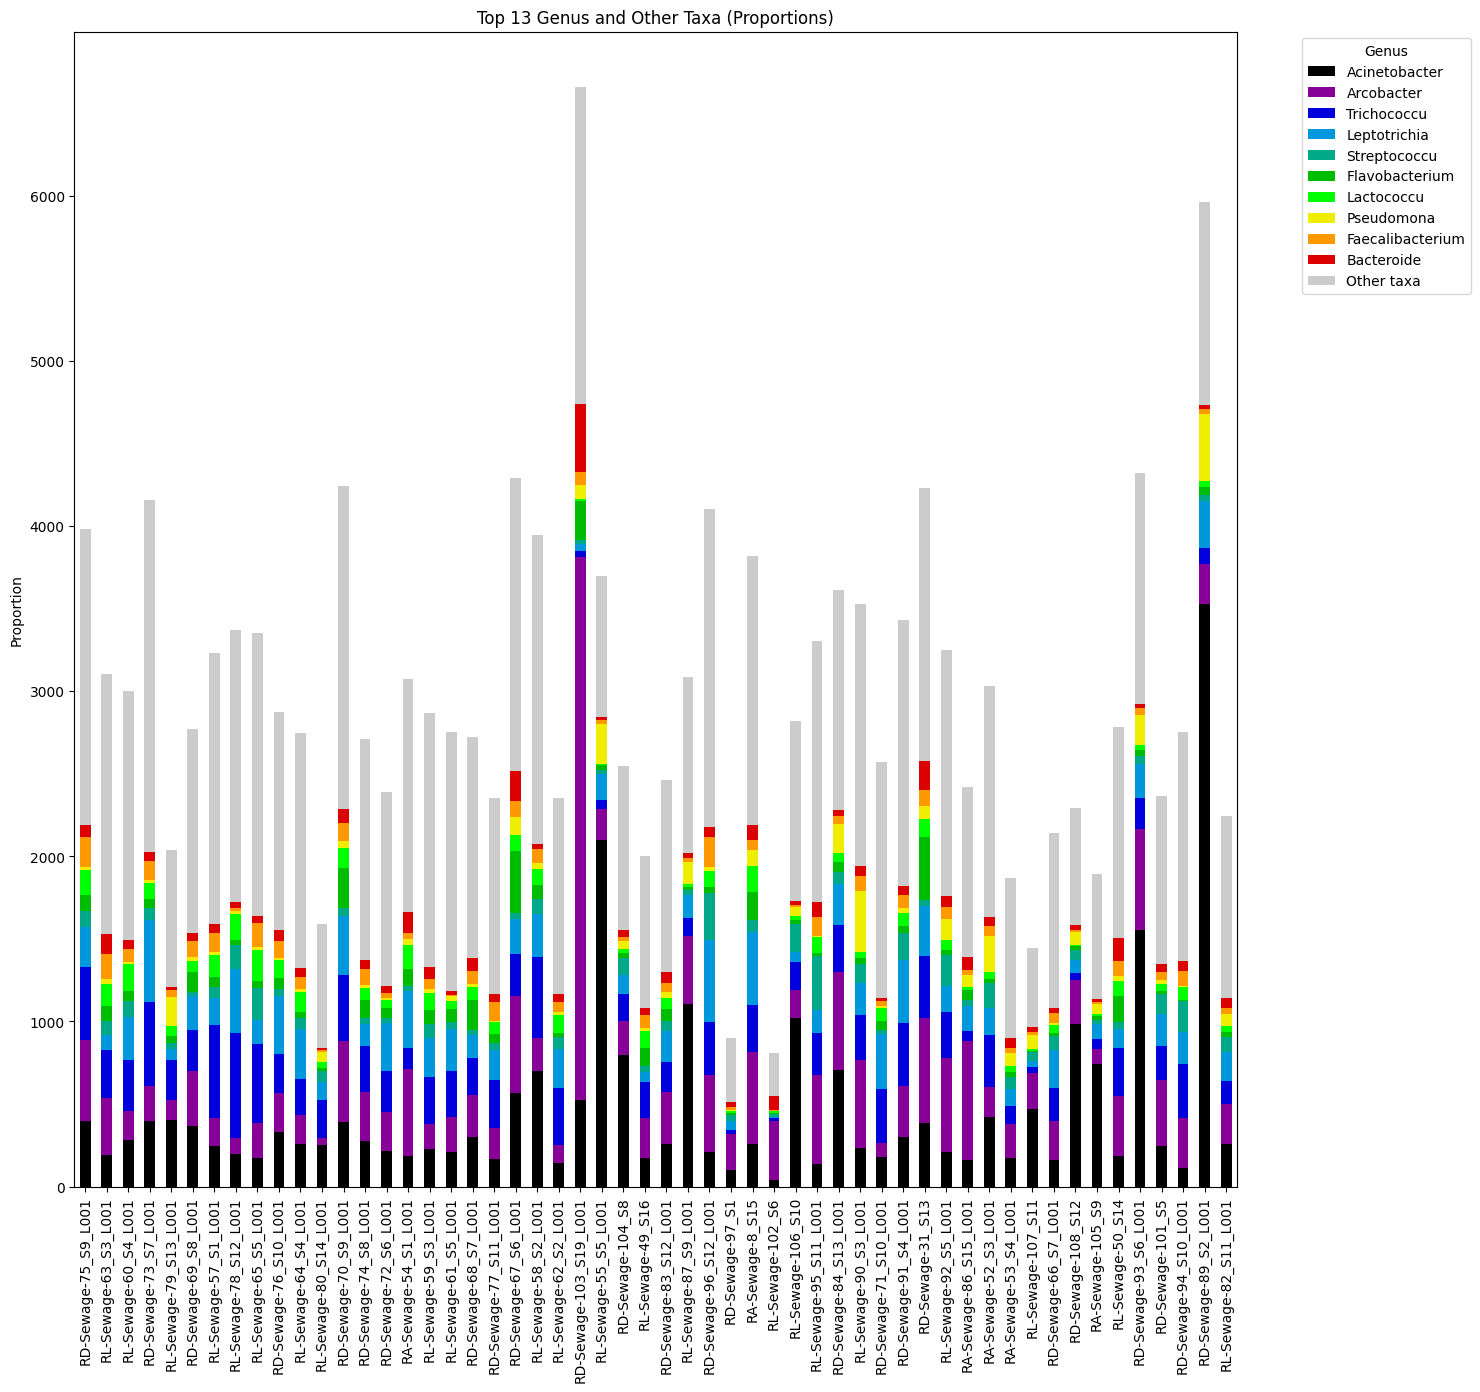

In [208]:
ax = top_10.plot(
    kind='bar', 
    stacked=True, 
    figsize=(15, 15), 
    title="Top 13 Genus and Other Taxa (Proportions)",
    colormap='nipy_spectral',
)
ax.set_ylabel("Proportion")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Genus')

In [ ]:

adata_keeper.var['Other taxa'] = pd.Series(adata[:, others].X.sum(axis=1), index=adata.obs.index, name='Other taxa')
adata_keeper.to_df()

In [146]:
pd.Series(adata[:, others].X.sum(axis=1), index=adata.obs.index, name='Other taxa')

sample_3     1798.0
sample_4     1575.0
sample_5     1511.0
sample_6     2132.0
sample_7      826.0
sample_8     1235.0
sample_9     1639.0
sample_10    1646.0
sample_11    1712.0
sample_12    1322.0
sample_13    1422.0
sample_14     752.0
sample_15    1958.0
sample_16    1334.0
sample_17    1178.0
sample_18    1413.0
sample_19    1537.0
sample_20    1569.0
sample_21    1336.0
sample_22    1186.0
sample_23    1774.0
sample_24    1873.0
sample_25    1190.0
sample_26    1922.0
sample_27     852.0
sample_28     997.0
sample_29     919.0
sample_30    1167.0
sample_31    1065.0
sample_32    1926.0
sample_33     390.0
sample_34    1631.0
sample_35     259.0
sample_36    1085.0
sample_37    1582.0
sample_38    1332.0
sample_39    1586.0
sample_40    1428.0
sample_41    1614.0
sample_42    1656.0
sample_43    1485.0
sample_44    1034.0
sample_45    1400.0
sample_46     972.0
sample_47     479.0
sample_48    1059.0
sample_49     708.0
sample_50     757.0
sample_51    1281.0
sample_52    1399.0
